# Richter's Predictor: Modeling Earthquake Damage
## Bishwas Ghimire
 
The goal of this project is to spot high-risk structures to prepare for future earthquakes by accurately predicting the level of damage to buildings caused by the Nepal 2015 earthquake based on aspects of building location and construction. The problem was hosted on [Driven Data](https://www.drivendata.org/competitions/57/nepal-earthquake/)  in the form of an open machine learning challenge for learning purposes with the title 'Richter's Predictor: Modeling Earthquake Damage'. 

The data was collected through surveys by the Central Bureau of Statistics that work under the National Planning Commission Secretariat of Nepal. This is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

Training data, training labels, and test data were provided. The goal is to develop a predictive model using the training set and the training labels (the truth). The best model developed will then be used to predict the target variable for the submission test set. 

#### *Some bookkeeping stuff*
*To avoid cluttering this report with plenty of code, we will import support.ipynb that has all the supporting code such as standard imports, plots, preprocessing, and other miscellaneous functions. If there is a need to include any block of code to help explain or clarify any concept or action, we will include that again here. Some code chunks take a long time to run; they have been commented out to avoid long wait time.*

Let's begin by running support.ipynb that will also import the data.

In [1]:
%run support.ipynb
display(target.head())
display(features.head())

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


## Data Summary
The target in our problem is categorial with three distinct damage levels; 1, 2, 3 ordered from low to high level of damage. We have a multi-class classification problem with three ordered classes.

Features have information on aspects of structure's location and construction. For instance, three distinct *geo_level_id_#*'s (1,2, and 3 respectively) represent the district, municipality/VDC and ward location of the surveyed structure. *foundation_type, roof_type, has_superstructure_mud*, and many others like these give us information on different aspects of the building's construction. Some features are continuous, for example age, height percentage, etc., but most are categorical. Among the categorical ones, most are dummies, some have a few categories encoded with strings, and a few like *geo_level_2_id* and *geo_level_3_id* have way too many categories (more than 100) inside them. These different cases need to be handled accordingly. 

In some of the categorical varaibles, the competition moderators do not tell us what the encoded characters representing different levels of the categorical variable really mean in the physical context of the structure. We were able to find the original dataset from which the data for this competition has mostl likely been subsampled. From that, we have gotten some more information on what different levels in each category could possiblly mean; however, we have not yet fully worked out what the character-encoded levels in some of our categorical variables exactly mean in the physical context. 

## Data Exploration
As soon as we begin inspecting the target variable, we see that there is a potential problem in our target. 
### Class Imbalace
Let's plot the class frequency distribution for our three damage levels. 

Relative Frequency


2    0.568912
3    0.334680
1    0.096408
Name: damage_grade, dtype: float64

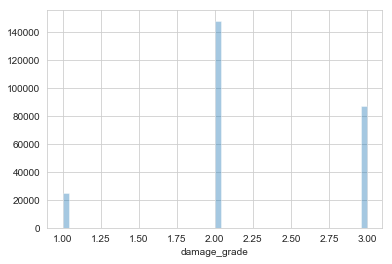

In [10]:
sns.set_style('whitegrid')
sns.distplot(target['damage_grade'], kde = False)
print("Relative Frequency")
target['damage_grade'].value_counts()/np.sum(target['damage_grade'].value_counts())

We can see that less than 10% of the structures have damage level 1 while almost 60% of the structures have damage level 2. We tried several things to address this imbalance of classes and to see if we can improve our model performance by doing so. A typically solution to class imbalance problem that is suggested by most of the data science community is resampling (either undersampling or oversampling). We first tried balancing by using the hyperparameter class_weight inside the machine learning models, but to our surprise, model performance declined when class_weight was set to 'balanced'. 

We then tried explicitly resampling the dataset before feeding it to the model using an oversampling technique called SMOTE inside the package imblearn. That seemed to increase the model performance significantly on the training set but not as much on the test set. We also tried undersampling, which didn't seem to help. 

We implement SMOTE resampling on the training set after constructing the design matrix and doing the train-test split.

### Visualization
Let's explore the dataset by making some plots. 

#### Violinplot
To visually explore the continuous features in the dataset, we can use seaborn's violinplot function to plot the distribution by different damage grades. 

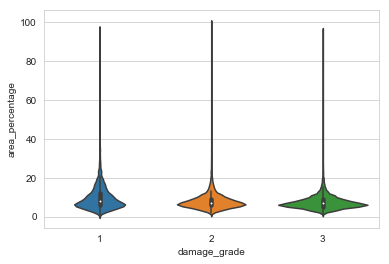

In [11]:
sns.violinplot(x="damage_grade", y="area_percentage", data=features.join(target.astype('category')))

#### Catplot
Seaborn's catplot is even better as it allows us to control the plot type. Plus, we can look into different levels inside each category as shown below.

(-10, 40)

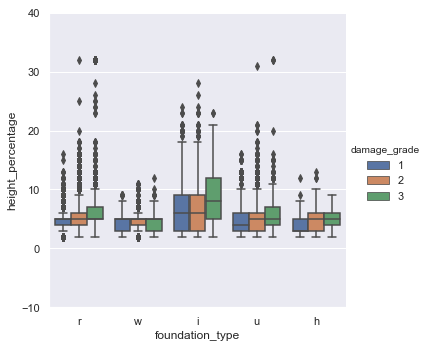

In [58]:
g = sns.catplot(x="foundation_type", y="height_percentage", hue="damage_grade",
                data=features.join(target.astype('category')), kind="box")
plt.ylim(-10,40)

#### More plots
Below, we have a histogram of *geo_level_1_id* by different damage levels. We can see one region with almost a third of damage level 1 structures and another similar region for target level 3. 

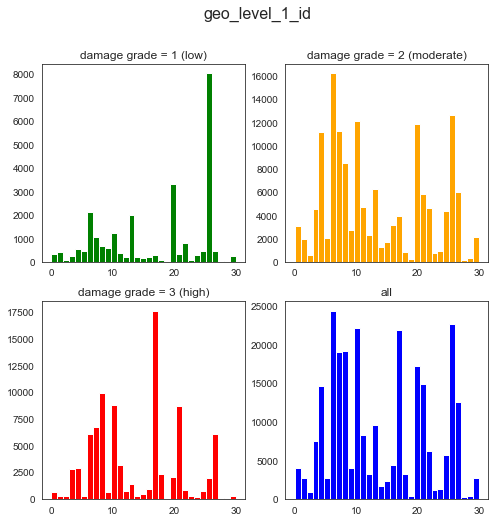

In [10]:
fig1

## Preprocessing and Feature Engineering
First step is to preprocess the original dataset. This usually means handling missing values, outliers etc.  Looking at the summary info of the feature and target variables (feature.info() and target.info()), we know we don't have missing values in our dataset. All of our features are either categorical or continuous within a given defined range, so outliers are not an issue (need to rethink here). 

We might however want to select a subset of features, or we might want to engineer some of the features, for instance, by scaling the values of a given feature or adding a feature that is derived from others. Most of our project time was spent on feature engineering. After trying many different models with different combinations of engineerd features and investigating the results, we have come up with the best set of features that gives the best performance so far. 
Some of the things we have tried are:
* scale continuous features using MinMax or Standard scaler depending on the classification algorithm used
* group together different levels of categorical features that seem to have same kind of damage distribution
* define new dummies to represent 'zones' that had the minimal or maximal damage
* rank features by 'feature_importances' given by algorithms like RandomForest and drop the ones that are least important
* combine several dummies together
* discretize *geo_level_id*'s that encode location information using KBinsDiscretizer (try different bin size and binning strategies), etc.

After going through the process of feature engineering and hyperparameter tuning with many different combination of subsets of features and models, we have settled on a set of features for our design matrix. Here, we will simply call a function in the support file to retrieve our desgin matrix.   

Some of the original features have been dropped due to their lower importance confirmed by certain algorithms, while some categorical features have been grouped in different ways to create new ones. 

One thing that really strikes out and that we should point out is even though *geo_level_id*'s are in reality categorical such as district, VDC, ward, etc. where numbers don't have a physical meaning other than representing a category, we acheived better performance when treating *geo_level_id*'s as continuous variables rather than using them as discretized categories, especially with RandomForest which has been our best performing algorithm so far. The reason might be because the numbers assigned for these geo level categories might not be entirely random. When we look at the histogram of the damaged structures by say *geo_level_1_id*, we see a smoothly changing pattern in the histogram, not something completely random. 

In [2]:
X = design_matrix(features)
y = target['damage_grade']
print(f'shape of X: {X.shape}')
# X[1,:]

shape of X: (260601, 23)


Matrix X is the design matrix whose columns are constructed by pre-processing and/or engineering a subset of original features that we find most important and/or influential for our problem. In this context, X has information on aspects of building construction and location that we choose to include. 

Simiarly, y is the target with categorical traning labels that tell us the true level of damage that each building suffered (1, 2, or 3). 

## Train-test split
We need to split the whole data (X and y) into train and test set for cross-validation. This test set is different from the final test set for the competition that we will have to submit predictions for. This sort of inner loop of train-test split of the original 'training data' is important as it will allow us to evaluate our model performance on the sequestered test set locally before using the model to submit predictions on the original test set handed to us. 

In [3]:
# do the local test-train split for cross-validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train[:1]

array([[0.7, 0.7140854940434478, 0.5796132728574839, 0.0,
        0.0050251256281407045, 0.0202020202020202, 0.0,
        0.1111111111111111, False, False, True, False, False, False, 0,
        1, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

## Resampling using SMOTE
Let's also go ahead and handle the issue of imbalanced classes explicitly by oversampling with SMOTE.

Using TensorFlow backend.


(400398,)


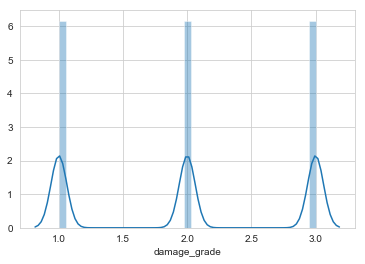

In [4]:
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
# usm =  RandomUnderSampler(sampling_strategy='not minority', random_state=42)
sm = SMOTE(random_state=42)
X_train, y_train =sm.fit_resample(X_train, y_train)
print(y_train.shape)
sns.set_style('whitegrid')
sns.distplot(y_train, hist=True)

## Baseline Model
Now that we have produced our training set and test set, let's build a simple baseline model using naive Bayesian classifier on the traning set using scikit learn's MultinomialNB classier that can handle a target variable with multiple categories.  Let's test the model on the test set and plot a cross-validation curve. 

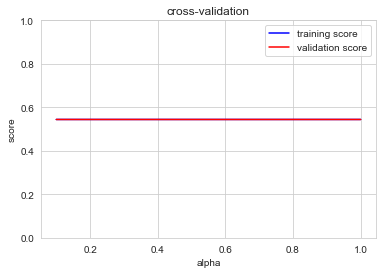

Mean validation score:0.5441


In [6]:
#initialize model and set model parameters
model = MultinomialNB()
alpha = np.linspace(0.1,1,3)
k = 3

#get training and validation score 
train_score, val_score = validation_curve(model, X_train, y_train,
                                      'alpha', alpha, cv=k)
#plot the results
fig3 = plt.figure()
ax=fig3.add_subplot(1,1,1)
ax.set_title('cross-validation')
ax.plot(alpha, np.mean(train_score, 1), 
        color='blue', label='training score')
ax.plot(alpha, np.mean(val_score, 1), 
        color='red', label='validation score')
ax.legend(loc='best')
ax.set_ylim(0, 1)
ax.set_xlabel('alpha')
ax.set_ylabel('score')
#fig.set_size_inches(10, 10.5)
sns.set_style("whitegrid")
plt.show()
print('Mean validation score:{:.4f}'.format(np.mean(val_score)))

The validation curve above shows that the hyperparameter $\alpha$ doesn't really affect our model performance. Our validation score is about 0.57. This exercise is mostly useful for quickly visualizing the training and validation score. What is also desirable is to tune the hyperparameters to make the model more efficient and find the best performing model along with its parameters. This can be done by using sklearn's GridsearchCV.

## GridsearchCV
Below, we use gridsearchCV to search through the selected hyperparameter space of a Random Forest Classifier to find the best set of parameters and hyperpameters for our model. 

In [10]:
# use gridsearch to find the best parameter
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score 

#initialize model and set model parameters
cw_bal_under = {3:1 ,2:0.2, 1:3}
model = RandomForestClassifier()
k = 10

param_grid = {'n_estimators': [50], #[20, 50, 100],
#              'class_weight': [None], #, ['balanced', cw_bal_under],
             'min_samples_leaf' : [2],  # [2,3,5,10]
             'min_samples_split': [2]   # [2,6,10]
             }
gs = GridSearchCV(model, param_grid, cv=k)

gs.fit(X_train,y_train)
print(f'best estimator: {gs.best_estimator_}')
print(f'best validation score: {gs.best_score_}')

#print f-1 score using the best model
y_pred = gs.predict(X_test) 
print('f1-score on test set:{}'.format(f1_score(y_test, y_pred, average ='micro')))

best estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
best validation score: 0.815391477949359
f1-score on test set:0.7129043398181191


As we can see, we can performing really well on the trainig set but not as much on the test set. One reason might be the fact that the training set has been resampled, while the test set is not, so the model prediction might not be translating very well to the data that has a different class distribution. We are working on resolving this issue.

For now, let's pick the best estimator from the grid search and use that to fit the data. We will use this model later to generate performance metrics. 

## More Classifiers: GridsearCV with Pipeline
Now that we can construct and tune one model using grid search, let's try to do that for multiple models. Let's use sklearn's GridsearchCV with pipeline to run a few different classifiers. The classifiers are consider are:
* Random Forest Classifier
* Logistic Regression
* Gradient Boosting Classifier

Below, we run four different classifiers each with their own sets of model parameters using gridsearchCV and pipeline. This code takes a long time to run, so we have attached an image of one of our previous results just in case.

##############################
RandomForestClassifier
micro-averaged F1 score:0.7150
##############################
LogisticRegression
micro-averaged F1 score:0.4724
##############################
GradientBoostingClassifier
micro-averaged F1 score:0.5930


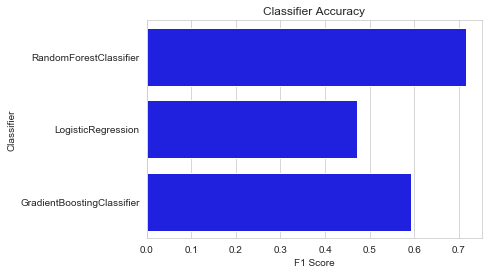

In [5]:
#this code takes long time to run
if False:
    model1 = RandomForestClassifier(max_features= "auto",random_state=42)
    param_model1 = {
                  'randomforestclassifier__n_estimators': [50],
                  'randomforestclassifier__min_samples_leaf': [2],
                  'randomforestclassifier__min_samples_split': [2],
    #               'randomforestclassifier__criterion': [ 'gini','entropy'],
    #               'randomforestclassifier__class_weight': [None, 'balanced']
                 }
    # Model 2: Logistic Regression
    model2 = LogisticRegression(random_state=42, solver='saga',
                                multi_class='ovr')
    param_model2  = {'logisticregression__C': [1], 
    #                  'logisticregression__class_weight' : [None, 'balanced']
                    }

    # Model 3: SVC
    model3 = SVC(random_state=42)
    param_model3 = {'svc__kernel':['linear'], #('linear','poly', 'rbf')
                    'svc__C':[0.1],  # [0.25, 0.5, 1, 10]
                    'svc__gamma': ['scale'],
                    'svc__decision_function_shape':['ovr']
                   }

    # Model 4: Gradient Boosting
    model4 = GradientBoostingClassifier(model1)
    param_model4 = {'gradientboostingclassifier__n_estimators' : [20], #[20, 50,80]
                    'gradientboostingclassifier__learning_rate' : [0.1], #[1, 5, 10 ]
                    'gradientboostingclassifier__min_samples_leaf' : [2], 
                    'gradientboostingclassifier__min_samples_split': [2],
                    'gradientboostingclassifier__loss': ['deviance'],
    #                 'gradientboostingclassifier__class_weight': [None, 'balanced']
                   }

    # models and parameters in a ordered list
    classifiers = [model1, model2, model4]
    params = [param_model1, param_model2, param_model4]

    # logging classifier performance
    perf_cols = ["Classifier", "Parameter", "F1_Score"]
    performance_log = pd.DataFrame(columns=perf_cols)

    for classifier,param in zip(classifiers,params):
        print('#'*30)
        print(classifier.__class__.__name__)
        pipe = make_pipeline(classifier)
        gs = GridSearchCV(pipe, param, cv=10)
        gs.fit(X_train, y_train)


        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test) 
        f1 = f1_score(y_test, y_pred, average ='micro')
        print('micro-averaged F1 score:{:.4f}'.format(f1))

        log_entry = pd.DataFrame([[classifier.__class__.__name__, gs.best_params_, f1]], columns=perf_cols)
        performance_log = performance_log.append(log_entry)

    import seaborn as sns
    import matplotlib.pyplot as plt
    #sns.set_color_codes("muted")
    sns.barplot(x='F1_Score', y='Classifier', data=performance_log, color="b")
    performance_log.to_csv('performance_log.csv')

    plt.xlabel('F1 Score')
    plt.title('Classifier Accuracy')
    plt.show()

## Best Estimator

After trying different models and running grid search on several model hyperparameters, our best estimator so far is a Random Forest Classifier. Some of the model hyperparameters are:
- n_estimators = 50
- min_samples_leaf = 2
- min_samples_split = 2
- class_weight = None
- criterion = gini

The micro-averaged F-1 score for the best estimator is 0.715.

## Confusion matrix
Confusion matrix helps us diagnose where we are wrong by comapring trule labels with predicted labels. Let's go ahead and plot a confusion matrix for our prediction. 

To make our lives easier, the gridsearchCV ran with Random Forest Classifier above has the parameters of the best estimator. We can predict using that estimator and plot our confusion matrix.

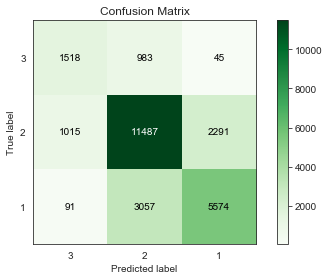

In [13]:
y_pred = gs.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
labels = target['damage_grade'].unique().astype('str')
sns.set_style('white')
plot2 = plot_confusion_matrix(y_test, y_pred, labels, normalize=False)

We are doing decently on classifying label 2 accurately, but we are misclassiflying a big fraction of the other two labels. Label 2 refers to damage level 2, and almost 60% of the data are damage level 2 structures. Class imbalance seems to be causing some problem, but as we mentioned before, we tried using 'balanced' class weights to address class imbalance, but that hurt rather than helped our model performance. We are looking into the reason why. Currently, the best micro-averaged F1 score is 0.725. We are working on improving it through feature engineering and by using ensemble models like gradient boosting classifiers.  

## ROC-AUC
ROC curve is a plot of true positive rates versus false positive rates across different probability thresholds set for classifying labels. AUC (area under the curve) is a measure of how good the model is in increasing true positive rate and reducing false positive rate. It ranges from 0.5 to 1, 0.5 being quivalent to random guess and 1 being perfect. 

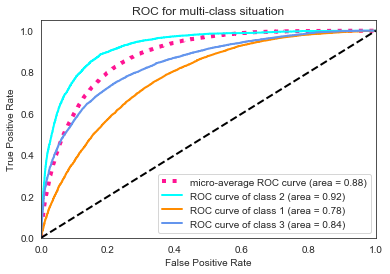

In [14]:
y_pred = gs.predict_proba(X_test)
y_test_dum = pd.get_dummies(y_test).values
plot_ROC(y_test_dum,y_pred)


# Conclusion
We have developed a Random Forest Classifier that classifies buildings surveyed after the 2015 Nepal earthquake into three damage levels with a micro-averaged F-1 score of around 0.72. The top score in the current competition leaderboard is 0.7544. We are still working on improving our estimator via feature engineering and by addressing the issue caused by class imbalance. Oversampling using SMOTE seems to significantly improve performance on the train set, but it doesn't generalize very well to the test set. We are working on addressing this issue. In addition to this, we believe performance can be improved significantly if we can identify  the buildings that are getting misclassified by the classifier and look for things that are common in them. 